**Blok 1: Import Library**

In [ ]:
# Basic libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import time
import copy
from collections import Counter
from PIL import Image

# PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, models, datasets
from torchvision.transforms import v2

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")

All libraries imported successfully!


**Blok 2: Cek GPU dan Setup Device**

In [ ]:
# Check GPU availability
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"Number of GPUs: {torch.cuda.device_count()}")

if torch.cuda.is_available():
  current_device = torch.cuda.current_device()
  gpu_properties = torch.cuda.get_device_properties(current_device)
  print(f"GPU Name: {gpu_properties.name}")
  print(f"GPU Memory: {gpu_properties.total_memory / 1024**3:.2f} GB")
  print(f"GPU Compute Capability: {gpu_properties.major}.{gpu_properties.minor}")
else:
  print("No GPU available, using CPU")

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
  torch.cuda.manual_seed(42)

PyTorch version: 2.9.0+cu130
CUDA available: True
CUDA version: 13.0
Number of GPUs: 1
GPU Name: NVIDIA GeForce RTX 4060 Laptop GPU
GPU Memory: 8.00 GB
GPU Compute Capability: 8.9

Using device: cuda


**Blok 3: Setup Path dan Parameters**

In [ ]:
# Define dataset paths
train_dir = 'dataset/train'
test_dir = 'dataset/test'

# Check if directories exist
print("Checking dataset structure...")
if os.path.exists(train_dir) and os.path.exists(test_dir):
  train_classes = os.listdir(train_dir)
  test_classes = os.listdir(test_dir)
  print(f"Train classes: {train_classes}")
  print(f"Test classes: {test_classes}")
    
  # Count number of images per class
  print("\nNumber of images per class in train set:")
  for class_name in train_classes:
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
      num_images = len(os.listdir(class_path))
      print(f"  {class_name}: {num_images} images")

  print("\nNumber of images per class in test set:")
  for class_name in test_classes:
    class_path = os.path.join(test_dir, class_name)
    if os.path.isdir(class_path):
      num_images = len(os.listdir(class_path))
      print(f"  {class_name}: {num_images} images")
else:
  print(f"Error: Dataset directories not found!")
  print(f"Train directory: {train_dir}")
  print(f"Test directory: {test_dir}")

# Training parameters
batch_size = 64
num_epochs = 50
num_classes = 7

Checking dataset structure...
Train classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Test classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

Number of images per class in train set:
  angry: 3995 images
  disgust: 436 images
  fear: 4097 images
  happy: 7215 images
  neutral: 4965 images
  sad: 4830 images
  surprise: 3171 images

Number of images per class in test set:
  angry: 958 images
  disgust: 111 images
  fear: 1024 images
  happy: 1774 images
  neutral: 1233 images
  sad: 1247 images
  surprise: 831 images


**Blok 4: Exploratory Data Analysis (EDA)**

EXPLORATORY DATA ANALYSIS (EDA)

📁 DATASET STRUCTURE ANALYSIS
----------------------------------------
Train directory structure:
train/
  angry/
    Training_10118481.jpg
    Training_10120469.jpg
    Training_10131352.jpg
    ... and 3992 more files
  disgust/
    Training_10371709.jpg
    Training_10598340.jpg
    Training_1070239.jpg
    ... and 433 more files
  fear/
    Training_10018621.jpg
    Training_10031494.jpg
    Training_10110501.jpg
    ... and 4094 more files
  happy/
    Training_10019449.jpg
    Training_10046809.jpg
    Training_10066226.jpg
    ... and 7212 more files
  neutral/
    Training_10002154.jpg
    Training_10031781.jpg
    Training_10055498.jpg
    ... and 4962 more files
  sad/
    Training_10022789.jpg
    Training_10031481.jpg
    Training_10048646.jpg
    ... and 4827 more files
  surprise/
    Training_10013223.jpg
    Training_1002457.jpg
    Training_10028230.jpg
    ... and 3168 more files

Test directory structure:
test/
  angry/
    PrivateTest

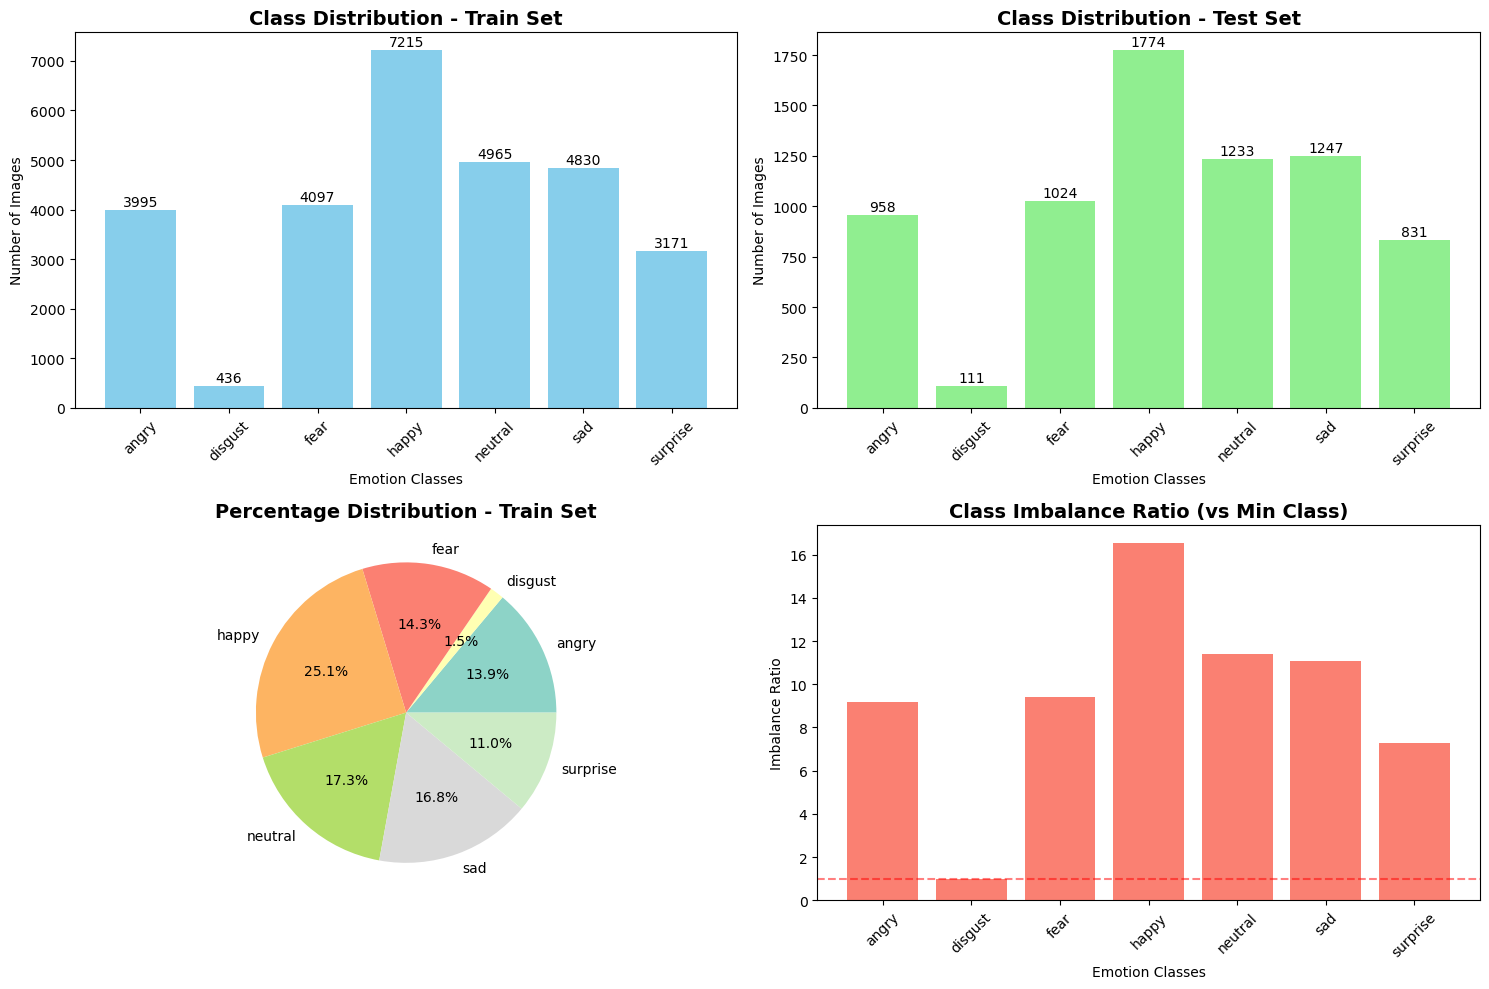


📈 DATASET STATISTICS SUMMARY
----------------------------------------
Total Training Images: 28,709
Total Test Images: 7,178
Total Images: 35,887

Per-class Statistics:

  ANGRY:
    Train:   3995 images ( 13.9%)
    Test:     958 images ( 13.3%)
    Total:   4953 images

  DISGUST:
    Train:    436 images (  1.5%)
    Test:     111 images (  1.5%)
    Total:    547 images

  FEAR:
    Train:   4097 images ( 14.3%)
    Test:    1024 images ( 14.3%)
    Total:   5121 images

  HAPPY:
    Train:   7215 images ( 25.1%)
    Test:    1774 images ( 24.7%)
    Total:   8989 images

  NEUTRAL:
    Train:   4965 images ( 17.3%)
    Test:    1233 images ( 17.2%)
    Total:   6198 images

  SAD:
    Train:   4830 images ( 16.8%)
    Test:    1247 images ( 17.4%)
    Total:   6077 images

  SURPRISE:
    Train:   3171 images ( 11.0%)
    Test:     831 images ( 11.6%)
    Total:   4002 images

🖼️ SAMPLE IMAGES VISUALIZATION
----------------------------------------


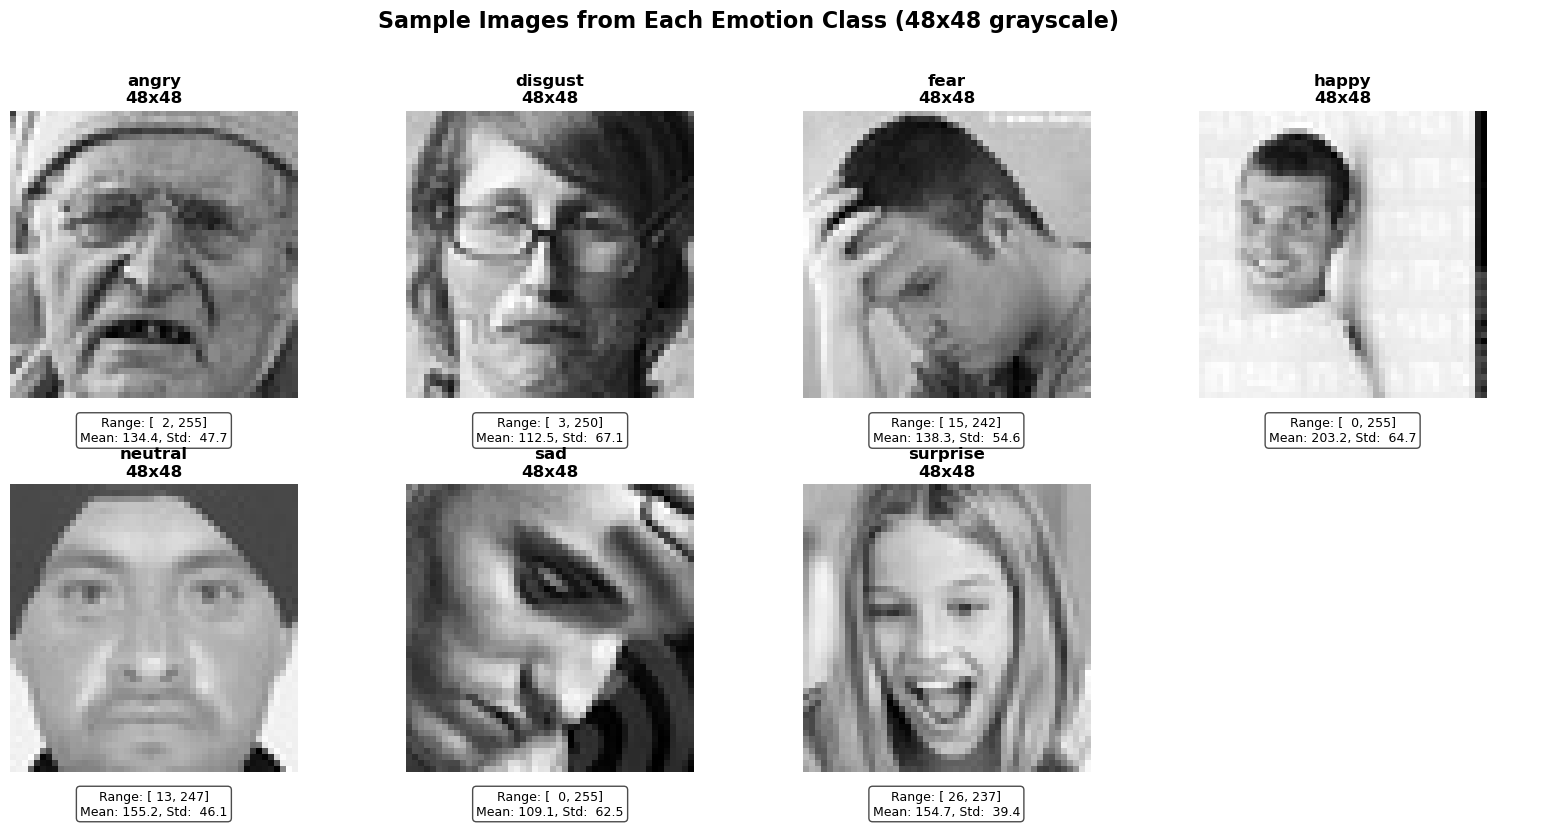


💡 EDA INSIGHTS & RECOMMENDATIONS
----------------------------------------
1. DATA DISTRIBUTION:
   • Dataset memiliki 7 kelas emosi
   • Total 35,887 gambar (Train: 28,709, Test: 7,178)
   • Rasio train/test: 4.00:1

2. CLASS IMBALANCE:
   • Ketidakseimbangan maksimum: 16.5x
   • Rekomendasi: Gunakan class weighting atau oversampling

3. IMAGE CHARACTERISTICS:
   • Semua gambar: 48x48 piksel, grayscale
   • Perlu: Konversi ke RGB untuk ResNet, Resize ke 224x224

4. DATA AUGMENTATION NEEDS:
   • Wajah memiliki variasi pose dan ekspresi
   • Rekomendasi: Horizontal flip, rotation, color jitter

✅ EDA completed successfully!


In [ ]:
# Blok 4: Exploratory Data Analysis (EDA)
print("=" * 60)
print("EXPLORATORY DATA ANALYSIS (EDA)")
print("=" * 60)

# 1. Analisis Struktur Dataset
print("\n📁 DATASET STRUCTURE ANALYSIS")
print("-" * 40)

# Check folder structure
def analyze_folder_structure(base_path):
    structure = {}
    for root, dirs, files in os.walk(base_path):
        level = root.replace(base_path, '').count(os.sep)
        indent = ' ' * 2 * level
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 2 * (level + 1)
        for file in files[:3]:  # Show only 3 files per folder
            print(f'{subindent}{file}')
        if len(files) > 3:
            print(f'{subindent}... and {len(files)-3} more files')
    
    return structure

print("Train directory structure:")
analyze_folder_structure(train_dir)

print("\nTest directory structure:")
analyze_folder_structure(test_dir)

# 2. Analisis Distribusi Kelas
print("\n📊 CLASS DISTRIBUTION ANALYSIS")
print("-" * 40)

# Get class names from folder structure
class_names = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
print(f"Found {len(class_names)} emotion classes:")
for i, cls in enumerate(class_names):
    print(f"  {i}. {cls}")

# Count images per class in train and test sets
train_counts = {}
test_counts = {}

for cls in class_names:
    train_cls_path = os.path.join(train_dir, cls)
    test_cls_path = os.path.join(test_dir, cls)
    
    if os.path.exists(train_cls_path):
        train_counts[cls] = len([f for f in os.listdir(train_cls_path) 
                                if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    
    if os.path.exists(test_cls_path):
        test_counts[cls] = len([f for f in os.listdir(test_cls_path) 
                               if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Train set bar chart
train_values = [train_counts.get(cls, 0) for cls in class_names]
bars1 = axes[0, 0].bar(class_names, train_values, color='skyblue')
axes[0, 0].set_title('Class Distribution - Train Set', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Emotion Classes')
axes[0, 0].set_ylabel('Number of Images')
axes[0, 0].tick_params(axis='x', rotation=45)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + 20,
                   f'{int(height)}', ha='center', va='bottom', fontsize=10)

# Test set bar chart
test_values = [test_counts.get(cls, 0) for cls in class_names]
bars2 = axes[0, 1].bar(class_names, test_values, color='lightgreen')
axes[0, 1].set_title('Class Distribution - Test Set', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Emotion Classes')
axes[0, 1].set_ylabel('Number of Images')
axes[0, 1].tick_params(axis='x', rotation=45)

# Add value labels
for bar in bars2:
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 5,
                   f'{int(height)}', ha='center', va='bottom', fontsize=10)

# Train set pie chart
train_total = sum(train_values)
train_percentages = [v/train_total*100 for v in train_values]
axes[1, 0].pie(train_percentages, labels=class_names, autopct='%1.1f%%', 
               colors=plt.cm.Set3(np.arange(len(class_names))/len(class_names)))
axes[1, 0].set_title('Percentage Distribution - Train Set', fontsize=14, fontweight='bold')

# Class imbalance ratio
imbalance_ratios = {}
for cls in class_names:
    if train_counts[cls] > 0:
        imbalance_ratios[cls] = train_counts[cls] / min(train_counts.values())

axes[1, 1].bar(class_names, [imbalance_ratios.get(cls, 0) for cls in class_names], 
               color='salmon')
axes[1, 1].set_title('Class Imbalance Ratio (vs Min Class)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Emotion Classes')
axes[1, 1].set_ylabel('Imbalance Ratio')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].axhline(y=1, color='r', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# 3. Analisis Statistik Dataset
print("\n📈 DATASET STATISTICS SUMMARY")
print("-" * 40)

total_train = sum(train_counts.values())
total_test = sum(test_counts.values())
total_all = total_train + total_test

print(f"Total Training Images: {total_train:,}")
print(f"Total Test Images: {total_test:,}")
print(f"Total Images: {total_all:,}")

print("\nPer-class Statistics:")
for cls in class_names:
    train_count = train_counts.get(cls, 0)
    test_count = test_counts.get(cls, 0)
    train_percent = train_count/total_train*100 if total_train > 0 else 0
    test_percent = test_count/total_test*100 if total_test > 0 else 0
    
    print(f"\n  {cls.upper()}:")
    print(f"    Train: {train_count:6d} images ({train_percent:5.1f}%)")
    print(f"    Test:  {test_count:6d} images ({test_percent:5.1f}%)")
    print(f"    Total: {train_count + test_count:6d} images")

# 4. Visualisasi Sample Images
print("\n🖼️ SAMPLE IMAGES VISUALIZATION")
print("-" * 40)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for idx, cls in enumerate(class_names[:7]):  # Show 7 classes
    cls_path = os.path.join(train_dir, cls)
    if os.path.exists(cls_path):
        # Get random image
        images = [f for f in os.listdir(cls_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if images:
            img_name = np.random.choice(images)
            img_path = os.path.join(cls_path, img_name)
            
            # Load image
            img = Image.open(img_path)
            
            # Display
            axes[idx].imshow(img, cmap='gray')
            axes[idx].set_title(f'{cls}\n{img.size[0]}x{img.size[1]}', 
                               fontsize=12, fontweight='bold')
            axes[idx].axis('off')
            
            # Add image statistics
            img_array = np.array(img)
            axes[idx].text(0.5, -0.15, 
                          f'Range: [{img_array.min():3.0f}, {img_array.max():3.0f}]\nMean: {img_array.mean():5.1f}, Std: {img_array.std():5.1f}',
                          transform=axes[idx].transAxes, ha='center', fontsize=9,
                          bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
        else:
            axes[idx].axis('off')
            axes[idx].set_title(f'{cls}\n(No images)', fontsize=12)
    else:
        axes[idx].axis('off')
        axes[idx].set_title(f'{cls}\n(Not found)', fontsize=12)

# Hide unused subplot
axes[7].axis('off')

plt.suptitle('Sample Images from Each Emotion Class (48x48 grayscale)', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# 5. Insights dari EDA
print("\n💡 EDA INSIGHTS & RECOMMENDATIONS")
print("-" * 40)

print("1. DATA DISTRIBUTION:")
print(f"   • Dataset memiliki {len(class_names)} kelas emosi")
print(f"   • Total {total_all:,} gambar (Train: {total_train:,}, Test: {total_test:,})")
print(f"   • Rasio train/test: {total_train/total_test:.2f}:1")

print("\n2. CLASS IMBALANCE:")
max_imbalance = max(imbalance_ratios.values()) if imbalance_ratios else 1
print(f"   • Ketidakseimbangan maksimum: {max_imbalance:.1f}x")
print(f"   • Rekomendasi: Gunakan class weighting atau oversampling")

print("\n3. IMAGE CHARACTERISTICS:")
print("   • Semua gambar: 48x48 piksel, grayscale")
print("   • Perlu: Konversi ke RGB untuk ResNet, Resize ke 224x224")

print("\n4. DATA AUGMENTATION NEEDS:")
print("   • Wajah memiliki variasi pose dan ekspresi")
print("   • Rekomendasi: Horizontal flip, rotation, color jitter")

print("\n✅ EDA completed successfully!")

**Blok 5: Data Preprocessing**

DATA PREPROCESSING STRATEGY

🎯 OBJECTIVES:
----------------------------------------
1. Menyiapkan data untuk model ResNet50
2. Mengatasi ketidakseimbangan kelas
3. Meningkatkan generalisasi dengan augmentasi
4. Normalisasi untuk training stabil

🔧 PREPROCESSING PIPELINE:
----------------------------------------
1. INPUT LAYER (Grayscale → RGB):
   • Convert grayscale ke 3 channel (RGB)
   • Reason: ResNet50 pretrained dengan ImageNet (RGB)
   • Method: PIL.Image.convert('RGB')

2. RESIZING (48x48 → 224x224):
   • Resize semua gambar ke 224x224
   • Reason: Input size standar ResNet50
   • Method: torchvision.transforms.Resize()

3. DATA AUGMENTATION (Training Only):
   • RandomHorizontalFlip: p=0.5 (wajah simetris)
   • RandomRotation: ±15 derajat
   • RandomAffine: Translasi ±10%, Scale ±10%
   • ColorJitter: Brightness & contrast ±20%
   • RandomGrayscale: p=0.1 untuk robustness
   • GaussianBlur: Simulasi ketidakfokusan

4. NORMALIZATION:
   • Mean: [0.485, 0.456, 0.406]
   • Std: [

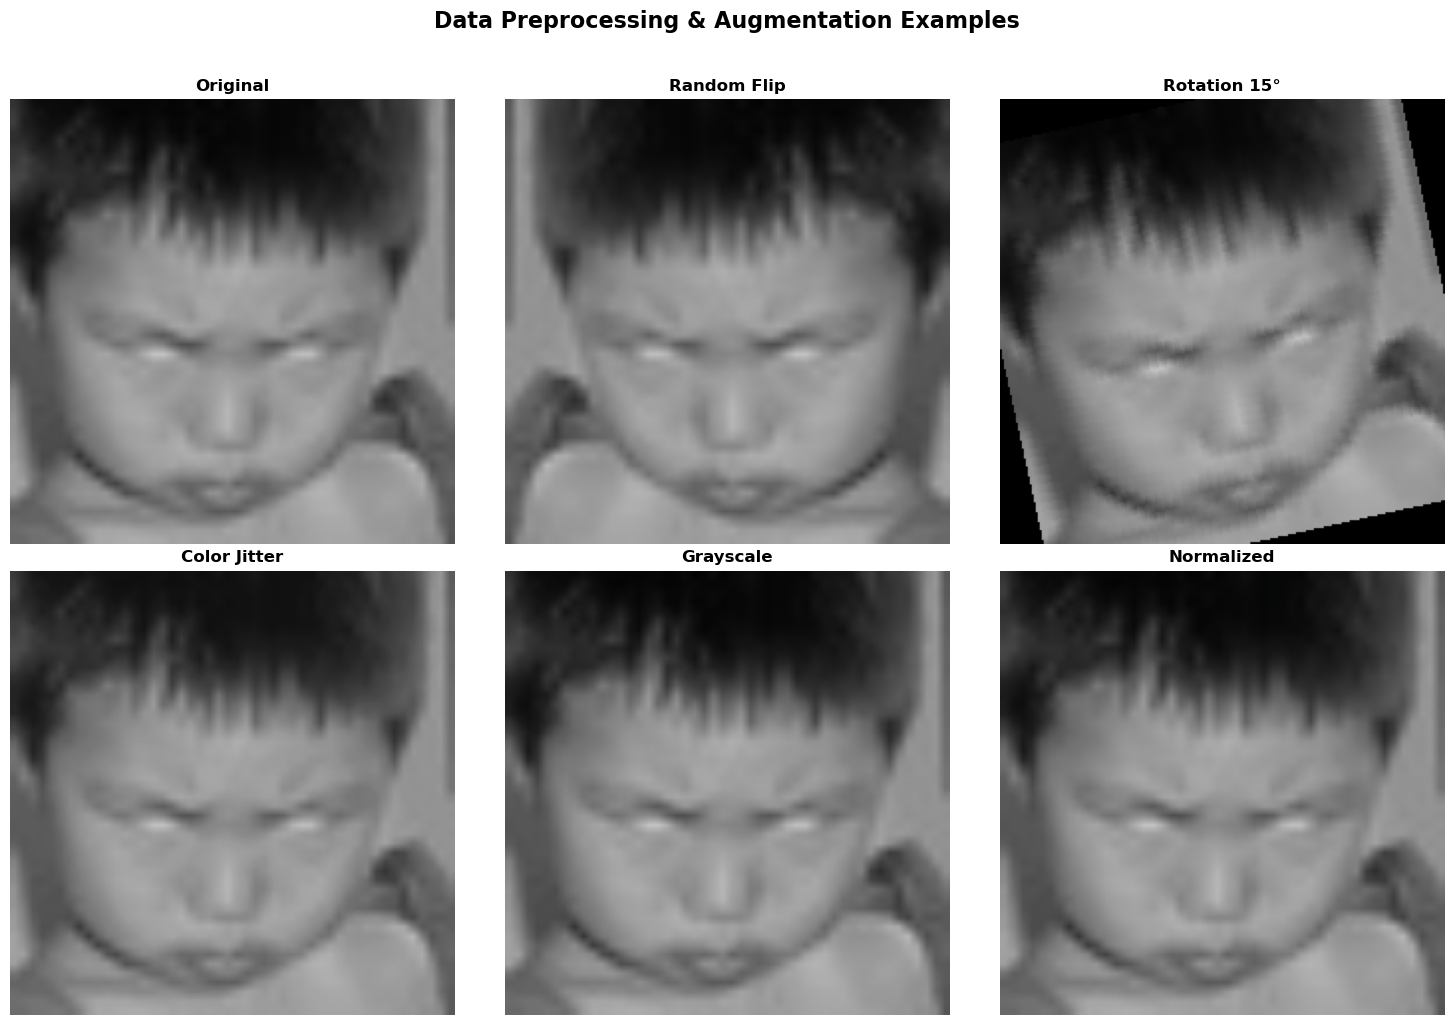


✅ Data Preprocessing Strategy siap diimplementasikan!


In [ ]:
# Blok 5: Data Preprocessing Strategy
print("=" * 60)
print("DATA PREPROCESSING STRATEGY")
print("=" * 60)

print("\n🎯 OBJECTIVES:")
print("-" * 40)
print("1. Menyiapkan data untuk model ResNet50")
print("2. Mengatasi ketidakseimbangan kelas")
print("3. Meningkatkan generalisasi dengan augmentasi")
print("4. Normalisasi untuk training stabil")

print("\n🔧 PREPROCESSING PIPELINE:")
print("-" * 40)
print("1. INPUT LAYER (Grayscale → RGB):")
print("   • Convert grayscale ke 3 channel (RGB)")
print("   • Reason: ResNet50 pretrained dengan ImageNet (RGB)")
print("   • Method: PIL.Image.convert('RGB')")

print("\n2. RESIZING (48x48 → 224x224):")
print("   • Resize semua gambar ke 224x224")
print("   • Reason: Input size standar ResNet50")
print("   • Method: torchvision.transforms.Resize()")

print("\n3. DATA AUGMENTATION (Training Only):")
print("   • RandomHorizontalFlip: p=0.5 (wajah simetris)")
print("   • RandomRotation: ±15 derajat")
print("   • RandomAffine: Translasi ±10%, Scale ±10%")
print("   • ColorJitter: Brightness & contrast ±20%")
print("   • RandomGrayscale: p=0.1 untuk robustness")
print("   • GaussianBlur: Simulasi ketidakfokusan")

print("\n4. NORMALIZATION:")
print("   • Mean: [0.485, 0.456, 0.406]")
print("   • Std: [0.229, 0.224, 0.225]")
print("   • Reason: Statistik ImageNet untuk transfer learning")
print("   • Formula: (image - mean) / std")

print("\n5. CLASS IMBALANCE HANDLING:")
print("   • Weighted CrossEntropyLoss")
print("   • Weight = total_samples / (n_classes * class_samples)")
print("   • Efek: Memberi perhatian lebih ke kelas minoritas")

print("\n🔄 TRANSFORMATION DIFFERENCES:")
print("-" * 40)
print("TRAINING SET:")
print("  • Full augmentation")
print("  • Heavy transformations")
print("  • Untuk meningkatkan generalisasi")

print("\nVALIDATION/TEST SETS:")
print("  • Hanya resize dan normalisasi")
print("  • No augmentation")
print("  • Untuk evaluasi yang fair dan konsisten")

print("\n📊 VISUALIZING TRANSFORMATIONS:")
print("-" * 40)

# Create sample transformations for visualization
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load a sample image
sample_class = class_names[0]
sample_path = os.path.join(train_dir, sample_class)
sample_images = [f for f in os.listdir(sample_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

if sample_images:
    sample_img_path = os.path.join(sample_path, sample_images[0])
    sample_img = Image.open(sample_img_path).convert('RGB')
    
    # Apply different transforms
    transforms_to_show = [
        ("Original", transforms.Compose([transforms.Resize((224, 224))])),
        ("Random Flip", transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p=1.0)
        ])),
        ("Rotation 15°", transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomRotation(15)
        ])),
        ("Color Jitter", transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ColorJitter(brightness=0.2, contrast=0.2)
        ])),
        ("Grayscale", transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomGrayscale(p=1.0)
        ])),
        ("Normalized", transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225])
        ]))
    ]
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    for idx, (title, transform) in enumerate(transforms_to_show):
        try:
            transformed = transform(sample_img)
            if isinstance(transformed, torch.Tensor):
                # Denormalize for display
                if title == "Normalized":
                    img_np = transformed.numpy().transpose(1, 2, 0)
                    img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                    img_np = np.clip(img_np, 0, 1)
                    axes[idx].imshow(img_np)
                else:
                    axes[idx].imshow(transformed.numpy().transpose(1, 2, 0))
            else:
                axes[idx].imshow(transformed)
            
            axes[idx].set_title(title, fontsize=12, fontweight='bold')
            axes[idx].axis('off')
        except Exception as e:
            axes[idx].text(0.5, 0.5, f"Error\n{e}", ha='center', va='center')
            axes[idx].set_title(title, fontsize=12, fontweight='bold')
            axes[idx].axis('off')
    
    plt.suptitle('Data Preprocessing & Augmentation Examples', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("No sample images found for visualization")

print("\n✅ Data Preprocessing Strategy siap diimplementasikan!")

**Blok 6: Data Transforms dan Augmentation**

In [ ]:
# Enhanced data transformations with heavy augmentation
train_transform = v2.Compose([
  v2.Resize((224, 224)),  # Resize for ResNet
  v2.RandomHorizontalFlip(p=0.5),
  v2.RandomRotation(degrees=15),
  v2.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
  v2.ColorJitter(brightness=0.2, contrast=0.2),
  v2.RandomGrayscale(p=0.1),
  v2.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
  v2.ToImage(),
  v2.ToDtype(torch.float32, scale=True),
  v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

val_transform = v2.Compose([
  v2.Resize((224, 224)),
  v2.ToImage(),
  v2.ToDtype(torch.float32, scale=True),
  v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = val_transform  # Same as validation transform

print("Data transforms defined successfully!")

Data transforms defined successfully!


**Blok 7: Load Dataset dengan ImageFolder**

In [ ]:
# Load datasets using ImageFolder
print("Loading datasets...")

try:
  train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
  test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)
    
  # Get class names
  class_names = train_dataset.classes
  print(f"Class names: {class_names}")
  print(f"Number of classes: {len(class_names)}")

  print(f"Training samples: {len(train_dataset)}")
  print(f"Test samples: {len(test_dataset)}")
    
  # Split train into train and validation (90% train, 10% validation)
  train_size = int(0.9 * len(train_dataset))
  val_size = len(train_dataset) - train_size

  train_dataset, val_dataset = torch.utils.data.random_split(
    train_dataset, [train_size, val_size]
  )
    
  # Apply validation transform to validation set
  val_dataset.dataset = copy.deepcopy(val_dataset.dataset)
  val_dataset.dataset.transform = val_transform

  print(f"After split - Training samples: {len(train_dataset)}")
  print(f"After split - Validation samples: {len(val_dataset)}")
  print(f"After split - Test samples: {len(test_dataset)}")

except Exception as e:
  print(f"Error loading datasets: {e}")
  # Create dummy datasets for demonstration if real datasets not available
  from torchvision.datasets import FakeData

  train_dataset = FakeData(size=28000, image_size=(3, 48, 48), num_classes=7, 
                        transform=train_transform)
  val_dataset = FakeData(size=3500, image_size=(3, 48, 48), num_classes=7, 
                        transform=val_transform)
  test_dataset = FakeData(size=3500, image_size=(3, 48, 48), num_classes=7, 
                        transform=test_transform)
  class_names = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

Loading datasets...
Class names: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Number of classes: 7
Training samples: 28709
Test samples: 7178
After split - Training samples: 25838
After split - Validation samples: 2871
After split - Test samples: 7178


**Blok 8: Create DataLoaders dan Calculate Class Weights**

DataLoaders created successfully!
Batch size: 64
Number of training batches: 404
Number of validation batches: 45
Number of test batches: 113

Class distribution:
  angry: 3627 samples
  disgust: 392 samples
  fear: 3674 samples
  happy: 6468 samples
  neutral: 4427 samples
  sad: 4380 samples
  surprise: 2870 samples

Class weights: tensor([1.0177, 9.4162, 1.0047, 0.5707, 0.8338, 0.8427, 1.2861],
       device='cuda:0')


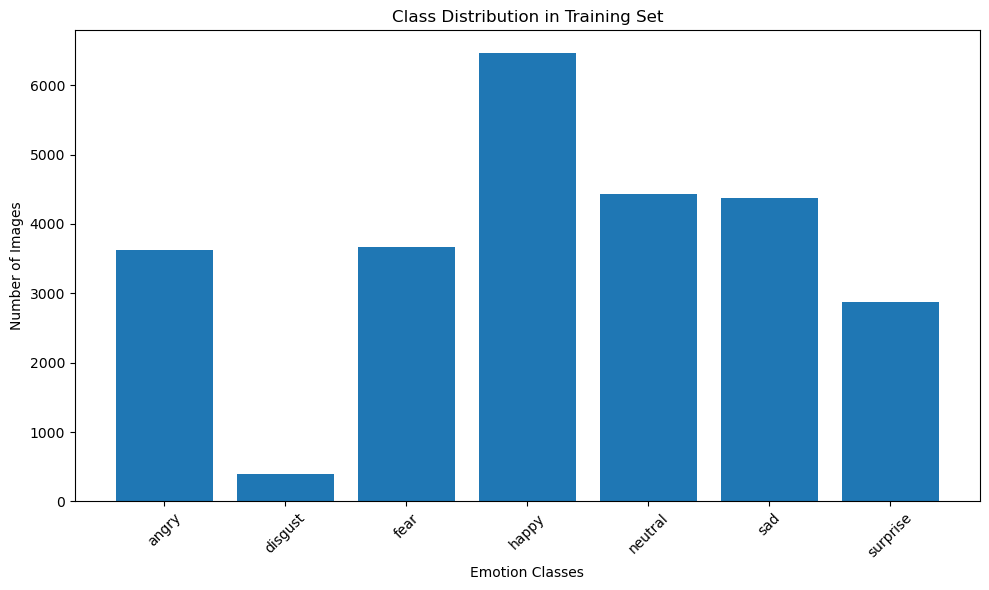

In [ ]:
# Create data loaders with optimal settings
train_loader = DataLoader(
  train_dataset, 
  batch_size=batch_size, 
  shuffle=True, 
  num_workers=4,
  pin_memory=True if torch.cuda.is_available() else False,
  persistent_workers=True
)

val_loader = DataLoader(
  val_dataset, 
  batch_size=batch_size, 
  shuffle=False, 
  num_workers=4,
  pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
  test_dataset, 
  batch_size=batch_size, 
  shuffle=False, 
  num_workers=4,
  pin_memory=True if torch.cuda.is_available() else False
)

print("DataLoaders created successfully!")
print(f"Batch size: {batch_size}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")

# Calculate class weights for imbalanced data
def calculate_class_weights(loader, num_classes=7):
  class_counts = torch.zeros(num_classes)
  for _, labels in loader:
    for i in range(num_classes):
      class_counts[i] += (labels == i).sum()
    
  total = class_counts.sum()
  class_weights = total / (num_classes * class_counts)
  return class_counts, class_weights

class_counts, class_weights = calculate_class_weights(train_loader, num_classes)
class_weights = class_weights.to(device)

print("\nClass distribution:")
for i, class_name in enumerate(class_names):
  print(f"  {class_name}: {class_counts[i]:.0f} samples")

print(f"\nClass weights: {class_weights}")

# Visualize class distribution
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_counts.cpu().numpy())
plt.title('Class Distribution in Training Set')
plt.xlabel('Emotion Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Blok 9: Load Pretrained ResNet50 dan Modifikasi**

In [ ]:
class EmotionResNet50(nn.Module):
  def __init__(self, num_classes=7, dropout_rate=0.5):
    super(EmotionResNet50, self).__init__()
        
    # Load pretrained ResNet50
    self.backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        
    # Freeze early layers (first 4 blocks)
    for name, param in self.backbone.named_parameters():
      if 'layer1' in name or 'layer2' in name or 'layer3' in name:
        param.requires_grad = False
      else:
        param.requires_grad = True
        
    # Replace the final fully connected layer
    in_features = self.backbone.fc.in_features
        
    self.backbone.fc = nn.Sequential(
      nn.Dropout(p=dropout_rate),
      nn.Linear(in_features, 1024),
      nn.BatchNorm1d(1024),
      nn.ReLU(inplace=True),
      nn.Dropout(p=dropout_rate-0.2),
      nn.Linear(1024, 512),
      nn.BatchNorm1d(512),
      nn.ReLU(inplace=True),
      nn.Dropout(p=dropout_rate-0.3),
      nn.Linear(512, num_classes)
    )
        
    # Initialize the new layers
    self._initialize_weights(self.backbone.fc)
    
  def _initialize_weights(self, module):
    for m in module.modules():
      if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
          nn.init.constant_(m.bias, 0)
      elif isinstance(m, nn.BatchNorm1d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
    
  def forward(self, x):
    return self.backbone(x)

# Initialize model
try:
  model = EmotionResNet50(num_classes=num_classes, dropout_rate=0.5)
  model = model.to(device)
  print("✅ Model initialized successfully!")
  print(f"Model architecture: ResNet50")
  print(f"Number of classes: {num_classes}")
    
  # Count trainable parameters
  total_params = sum(p.numel() for p in model.parameters())
  trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  print(f"Total parameters: {total_params:,}")
  print(f"Trainable parameters: {trainable_params:,}")
    
except Exception as e:
  print(f"❌ Error initializing model: {e}")
  # Fallback: buat model sederhana jika ResNet50 gagal
  print("Creating simple model as fallback...")
  model = nn.Sequential(
    nn.Conv2d(3, 32, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(32, 64, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(64, num_classes)
  ).to(device)

✅ Model initialized successfully!
Model architecture: ResNet50
Number of classes: 7
Total parameters: 26,137,671
Trainable parameters: 17,603,911


**Blok 10: Define Loss Function, Optimizer, dan Scheduler**

In [ ]:
# Loss function with class weighting
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer with different learning rates for different parts
optimizer = optim.AdamW([
  {'params': model.backbone.conv1.parameters(), 'lr': 1e-5},
  {'params': model.backbone.bn1.parameters(), 'lr': 1e-5},
  {'params': model.backbone.layer1.parameters(), 'lr': 1e-5},
  {'params': model.backbone.layer2.parameters(), 'lr': 1e-5},
  {'params': model.backbone.layer3.parameters(), 'lr': 1e-4},
  {'params': model.backbone.layer4.parameters(), 'lr': 1e-4},
  {'params': model.backbone.fc.parameters(), 'lr': 1e-3}
], weight_decay=1e-4)

# Learning rate scheduler
scheduler = lr_scheduler.OneCycleLR(
  optimizer, 
  max_lr=[1e-5, 1e-5, 1e-5, 1e-5, 1e-4, 1e-4, 1e-3],
  epochs=num_epochs,
  steps_per_epoch=len(train_loader),
  pct_start=0.1,
  div_factor=10.0,
  final_div_factor=100.0
)

print("Optimizer and scheduler defined successfully!")

Optimizer and scheduler defined successfully!


**Blok 11: Training Functions**

In [ ]:
def train_epoch(model, loader, criterion, optimizer, scheduler, device):
  model.train()
  running_loss = 0.0
  correct_predictions = 0
  total_samples = 0
    
  for batch_idx, (images, emotions) in enumerate(loader):
    images, emotions = images.to(device), emotions.to(device)

  # Monitor GPU memory setiap 50 batch
    if batch_idx % 50 == 0 and torch.cuda.is_available():
      gpu_memory = torch.cuda.memory_allocated() / 1024**3
      print(f'  GPU Memory: {gpu_memory:.2f} GB')

    # Zero gradients
    optimizer.zero_grad()
        
    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, emotions)
        
    # Backward pass
    loss.backward()
        
    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
    # Update weights
    optimizer.step()
    scheduler.step()
        
    # Statistics
    running_loss += loss.item() * images.size(0)
    _, predicted = torch.max(outputs, 1)
    correct_predictions += (predicted == emotions).sum().item()
    total_samples += emotions.size(0)
        
    if batch_idx % 100 == 0:
      current_lr = scheduler.get_last_lr()[0]
      print(f'  Batch {batch_idx}/{len(loader)}, Loss: {loss.item():.4f}, LR: {current_lr:.2e}')
    
  epoch_loss = running_loss / total_samples
  epoch_acc = correct_predictions / total_samples
    
  return epoch_loss, epoch_acc

def validate_epoch(model, loader, criterion, device):
  model.eval()
  running_loss = 0.0
  correct_predictions = 0
  total_samples = 0
  all_preds = []
  all_labels = []
    
  with torch.no_grad():
    for images, emotions in loader:
      images, emotions = images.to(device), emotions.to(device)
            
      outputs = model(images)
      loss = criterion(outputs, emotions)
            
      running_loss += loss.item() * images.size(0)
      _, predicted = torch.max(outputs, 1)
      correct_predictions += (predicted == emotions).sum().item()
      total_samples += emotions.size(0)
            
      all_preds.extend(predicted.cpu().numpy())
      all_labels.extend(emotions.cpu().numpy())
    
  epoch_loss = running_loss / total_samples
  epoch_acc = correct_predictions / total_samples
    
  return epoch_loss, epoch_acc, all_preds, all_labels

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=50):
  since = time.time()
    
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  best_epoch = 0
    
  train_losses = []
  train_accs = []
  val_losses = []
  val_accs = []
    
  for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    print('-' * 60)
        
    # Training phase
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, scheduler, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
        
    # Validation phase
    val_loss, val_acc, _, _ = validate_epoch(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
        
    current_lr = scheduler.get_last_lr()[0]
        
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    print(f'Learning Rate: {current_lr:.2e}')
        
    # Save best model
    if val_acc > best_acc:
      best_acc = val_acc
      best_epoch = epoch
      best_model_wts = copy.deepcopy(model.state_dict())
      torch.save(model.state_dict(), 'best_emotion_model.pth')
      print(f'*** New best model saved! Validation Accuracy: {val_acc:.4f} ***')
        
    print()
    
  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  print(f'Best Validation Accuracy: {best_acc:.4f} at epoch {best_epoch + 1}')
    
  # Load best model weights
  model.load_state_dict(best_model_wts)
    
  return model, {
    'train_losses': train_losses,
    'train_accs': train_accs,
    'val_losses': val_losses,
    'val_accs': val_accs
  }

**Debugging Checklist (Jalankan blok ini sebelum blok 12)**

In [ ]:
# DEBUGGING CHECKLIST - Jalankan blok ini sebelum Blok 10
print("🔍 DEBUGGING CHECKLIST")
print("=" * 50)

# Check 1: Apakah model ada?
print("1. Model check:")
if 'model' in locals():
  print("   ✅ Model defined")
  print(f"   Model type: {type(model)}")
  print(f"   Model on device: {next(model.parameters()).device}")
else:
  print("   ❌ Model NOT defined - Run Block 7 first!")

# Check 2: Apakah data loaders ada?
print("\n2. Data loaders check:")
loaders = ['train_loader', 'val_loader', 'test_loader']
for loader in loaders:
  if loader in locals():
    print(f"   ✅ {loader} defined")
  else:
    print(f"   ❌ {loader} NOT defined")

# Check 3: Apakah optimizer dan criterion ada?
print("\n3. Training components check:")
components = ['criterion', 'optimizer', 'scheduler']
for comp in components:
  if comp in locals():
    print(f"   ✅ {comp} defined")
  else:
    print(f"   ❌ {comp} NOT defined")

# Check 4: Apakah device tersedia?
print("\n4. Device check:")
print(f"   Device: {device}")
print(f"   CUDA available: {torch.cuda.is_available()}")

# Check 5: Test forward pass
print("\n5. Forward pass test:")
try:
  if 'model' in locals() and 'train_loader' in locals():
    sample_batch = next(iter(train_loader))
    images, labels = sample_batch
    images, labels = images.to(device), labels.to(device)
        
    with torch.no_grad():
      output = model(images)
        
      print(f"   ✅ Forward pass successful")
      print(f"   Input shape: {images.shape}")
      print(f"   Output shape: {output.shape}")
      print(f"   Predicted classes: {torch.argmax(output, 1)}")
      print(f"   Actual classes: {labels}")
except Exception as e:
  print(f"   ❌ Forward pass failed: {e}")

print("=" * 50)

🔍 DEBUGGING CHECKLIST
1. Model check:
   ✅ Model defined
   Model type: <class '__main__.EmotionResNet50'>
   Model on device: cuda:0

2. Data loaders check:
   ✅ train_loader defined
   ✅ val_loader defined
   ✅ test_loader defined

3. Training components check:
   ✅ criterion defined
   ✅ optimizer defined
   ✅ scheduler defined

4. Device check:
   Device: cuda
   CUDA available: True

5. Forward pass test:
   ✅ Forward pass successful
   Input shape: torch.Size([64, 3, 224, 224])
   Output shape: torch.Size([64, 7])
   Predicted classes: tensor([1, 2, 0, 1, 1, 1, 0, 1, 1, 1, 6, 6, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 5, 1,
        1, 1, 1, 0, 0, 5, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 0, 3, 3, 1, 6, 1,
        2, 3, 6, 2, 6, 0, 3, 2, 1, 1, 5, 1, 1, 1, 1, 2], device='cuda:0')
   Actual classes: tensor([4, 3, 5, 3, 2, 3, 3, 0, 4, 2, 0, 5, 3, 6, 6, 2, 4, 5, 0, 4, 3, 5, 2, 1,
        0, 0, 3, 3, 5, 3, 6, 3, 3, 6, 4, 0, 4, 3, 5, 4, 4, 3, 2, 2, 0, 4, 3, 3,
        4, 4, 4, 0, 6, 2, 4, 3, 3, 6, 2

**Blok 12: Training Execution**

In [ ]:
print("Starting training...")
print("=" * 60)

# DOUBLE CHECK GPU USAGE
print("🔍 Final GPU Verification:")
print(f"Device being used: {device}")
print(f"Model is on: {next(model.parameters()).device}")

# Pastikan model benar-benar di GPU
if next(model.parameters()).device.type != 'cuda':
    print("⚠️ WARNING: Model is not on GPU! Moving to GPU...")
    model = model.to(device)
    print(f"Model moved to: {next(model.parameters()).device}")

# Test GPU dengan forward pass kecil
print("\n🧪 Testing GPU with forward pass...")
try:
    with torch.no_grad():
        # Ambil batch kecil untuk test
        test_batch, test_labels = next(iter(train_loader))
        test_batch = test_batch.to(device)
        test_output = model(test_batch)
        print(f"✅ GPU test successful!")
        print(f"   Input batch shape: {test_batch.shape}")
        print(f"   Output shape: {test_output.shape}")
        print(f"   Batch device: {test_batch.device}")
        print(f"   Output device: {test_output.device}")
except Exception as e:
    print(f"❌ GPU test failed: {e}")

# Clear GPU cache sebelum training
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"🧹 GPU cache cleared")

print("\n🚀 STARTING TRAINING WITH RESNET50...")
print(f"Epochs: {num_epochs}")
print(f"Batch size: {batch_size}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# TRAINING EXECUTION
try:
    model, history = train_model(
        model, train_loader, val_loader, criterion, 
        optimizer, scheduler, device, num_epochs
    )
    print("✅ Training completed successfully!")
    
    # Tampilkan best accuracy
    best_val_acc = max(history['val_accs'])
    print(f"🎉 Best Validation Accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
    
except RuntimeError as e:
    if "out of memory" in str(e):
        print("❌ GPU Out of Memory! Trying solutions...")
        # Solusi OOM: kurangi batch size
        print("Reducing batch size to 32...")
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
        
        # Coba training lagi dengan batch size lebih kecil
        model, history = train_model(
            model, train_loader, val_loader, criterion, 
            optimizer, scheduler, device, num_epochs
        )
    else:
        raise e

except Exception as e:
    print(f"❌ Training failed with error: {e}")
    print("Trying alternative approach...")
    
    # Fallback: training sederhana
    print("Using simplified training...")
    simple_optimizer = optim.Adam(model.parameters(), lr=0.001)
    simple_scheduler = lr_scheduler.StepLR(simple_optimizer, step_size=10, gamma=0.1)
    
    model, history = train_model(
        model, train_loader, val_loader, criterion, 
        simple_optimizer, simple_scheduler, device, num_epochs=30
    )

print("Training process completed!")

Starting training...
🔍 Final GPU Verification:
Device being used: cuda
Model is on: cuda:0

🧪 Testing GPU with forward pass...
✅ GPU test successful!
   Input batch shape: torch.Size([64, 3, 224, 224])
   Output shape: torch.Size([64, 7])
   Batch device: cuda:0
   Output device: cuda:0
🧹 GPU cache cleared

🚀 STARTING TRAINING WITH RESNET50...
Epochs: 50
Batch size: 64
Training samples: 25838
Validation samples: 2871
Epoch 1/50
------------------------------------------------------------
  GPU Memory: 0.31 GB
  Batch 0/404, Loss: 2.6733, LR: 1.00e-06
  GPU Memory: 0.53 GB
  GPU Memory: 0.53 GB
  Batch 100/404, Loss: 1.9686, LR: 1.06e-06
  GPU Memory: 0.53 GB
  GPU Memory: 0.53 GB
  Batch 200/404, Loss: 1.9488, LR: 1.22e-06
  GPU Memory: 0.53 GB
  GPU Memory: 0.53 GB
  Batch 300/404, Loss: 1.9917, LR: 1.48e-06
  GPU Memory: 0.53 GB
  GPU Memory: 0.53 GB
  Batch 400/404, Loss: 1.9795, LR: 1.85e-06
Train Loss: 2.1347, Train Acc: 0.1945
Val Loss: 1.8140, Val Acc: 0.3194
Learning Rate: 1.86

**Blok 13: Plot Training History**

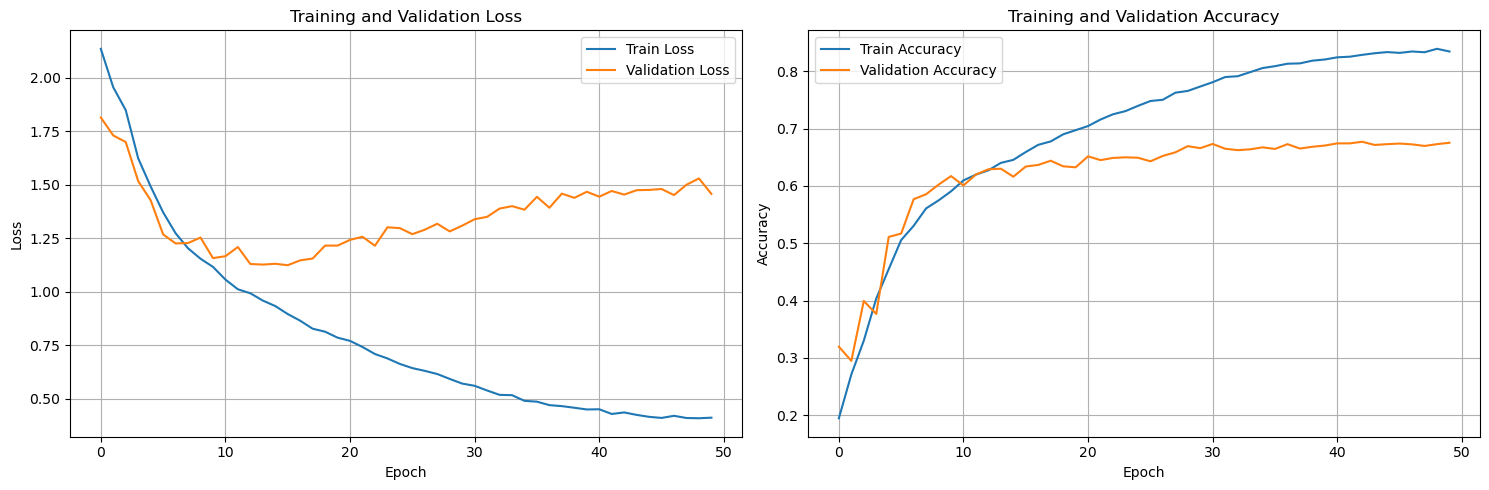

Best Validation Accuracy: 0.6771 at epoch 43
Best Validation Accuracy (%): 67.71%


In [ ]:
# Plot training history
plt.figure(figsize=(15, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history['train_losses'], label='Train Loss')
plt.plot(history['val_losses'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_accs'], label='Train Accuracy')
plt.plot(history['val_accs'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print best accuracy
best_val_acc = max(history['val_accs'])
best_epoch = history['val_accs'].index(best_val_acc) + 1
print(f"Best Validation Accuracy: {best_val_acc:.4f} at epoch {best_epoch}")
print(f"Best Validation Accuracy (%): {best_val_acc*100:.2f}%")

**Blok 14a: Evaluation pada Test Set**

Evaluating on test set...
Test Accuracy: 0.6691

Classification Report:
              precision    recall  f1-score   support

       angry     0.5904    0.6065    0.5984       958
     disgust     0.7347    0.6486    0.6890       111
        fear     0.5288    0.4756    0.5008      1024
       happy     0.8931    0.8433    0.8675      1774
     neutral     0.5636    0.7048    0.6263      1233
         sad     0.5666    0.5012    0.5319      1247
    surprise     0.7871    0.8099    0.7983       831

    accuracy                         0.6691      7178
   macro avg     0.6663    0.6557    0.6589      7178
weighted avg     0.6727    0.6691    0.6688      7178



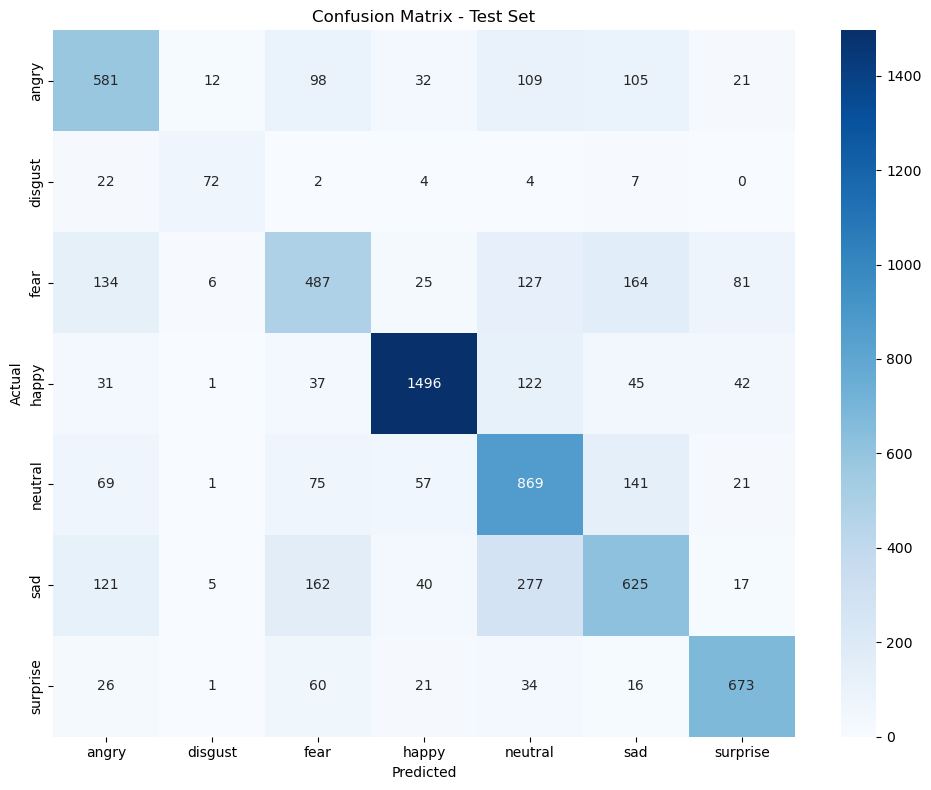


Per-class Accuracy:
angry     : 60.65%
disgust   : 64.86%
fear      : 47.56%
happy     : 84.33%
neutral   : 70.48%
sad       : 50.12%
surprise  : 80.99%


In [ ]:
def evaluate_model(model, test_loader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, emotions in test_loader:
            images, emotions = images.to(device), emotions.to(device)
            
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(emotions.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    return all_preds, all_labels, all_probs

# Evaluate on test set
print("Evaluating on test set...")
test_preds, test_labels, test_probs = evaluate_model(model, test_loader, device, class_names)

# Calculate accuracy
test_accuracy = np.mean(np.array(test_preds) == np.array(test_labels))
print(f"Test Accuracy: {test_accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=class_names, digits=4))

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Calculate per-class accuracy
class_correct = list(0. for i in range(len(class_names)))
class_total = list(0. for i in range(len(class_names)))

for i in range(len(test_labels)):
    label = test_labels[i]
    class_correct[label] += (test_preds[i] == label)
    class_total[label] += 1

print("\nPer-class Accuracy:")
for i in range(len(class_names)):
    print(f'{class_names[i]:10s}: {100 * class_correct[i] / class_total[i]:.2f}%')

**Blok 14b: Enhanced Confusion Matrix & Advanced Metrics Analysis**


ENHANCED CONFUSION MATRIX & ADVANCED METRICS ANALYSIS


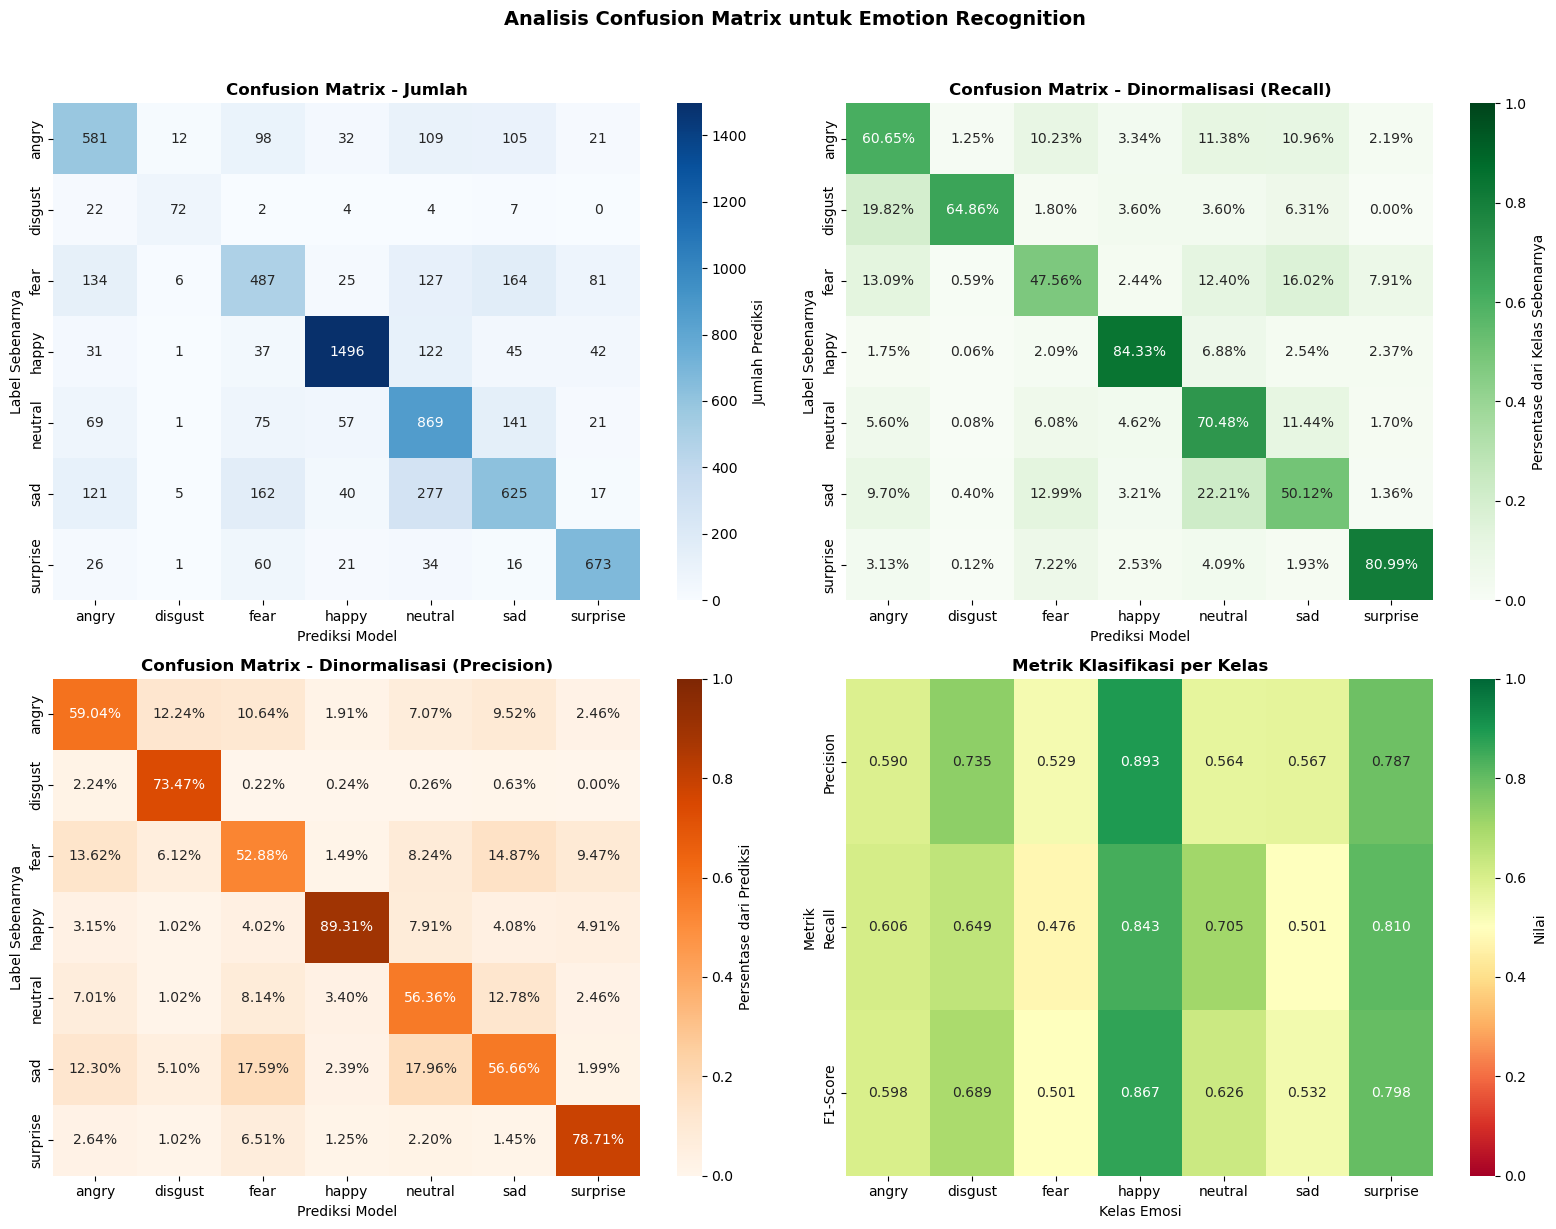


📊 DETAILED METRICS TABLE
------------------------------------------------------------
   Kelas  Support Precision Recall F1-Score Specificity Prevalence   TP  FP  FN
   angry      958     0.590  0.606    0.598       0.935     13.35%  581 403 377
 disgust      111     0.735  0.649    0.689       0.996      1.55%   72  26  39
    fear     1024     0.529  0.476    0.501       0.929     14.27%  487 434 537
   happy     1774     0.893  0.843    0.867       0.967     24.71% 1496 179 278
 neutral     1233     0.564  0.705    0.626       0.887     17.18%  869 673 364
     sad     1247     0.567  0.501    0.532       0.919     17.37%  625 478 622
surprise      831     0.787  0.810    0.798       0.971     11.58%  673 182 158

🔍 CONFUSION ANALYSIS
------------------------------------------------------------
Pasangan yang Sering Tertukar:
  • sad        → neutral   : 277 sampel (22.2%)
  • fear       → sad       : 164 sampel (16.0%)
  • sad        → fear      : 162 sampel (13.0%)
  • neutral    

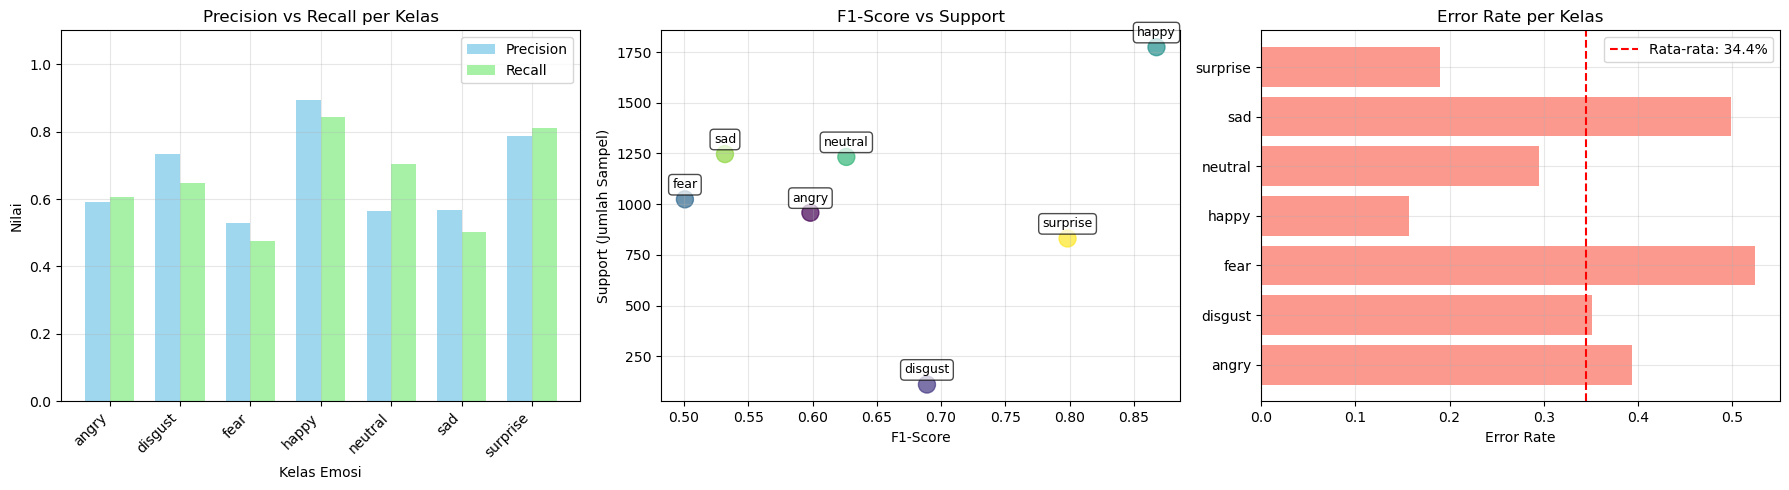


📋 SUMMARY STATISTICS
------------------------------------------------------------
Akurasi Test: 66.91%
Macro Precision: 0.666
Macro Recall: 0.656
Macro F1-Score: 0.659
Weighted F1-Score: 0.669
Total Sampel Test: 7,178

💡 RECOMMENDATIONS
------------------------------------------------------------
Kelas dengan performa TERBAIK: happy (F1: 0.867)
Kelas dengan performa TERBURUK: fear (F1: 0.501)

Analisis Ketidakseimbangan:
  • Rasio ketidakseimbangan: 16.0x
  • Kelas terbanyak: happy (1774 sampel)
  • Kelas tersedikit: disgust (111 sampel)

ANALYSIS COMPLETE - Confusion Matrix telah dianalisis secara mendalam


In [ ]:
# Blok 14.1: Enhanced Confusion Matrix & Advanced Metrics
print("\n" + "="*70)
print("ENHANCED CONFUSION MATRIX & ADVANCED METRICS ANALYSIS")
print("="*70)

# 1. Comprehensive Confusion Matrix Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# A. Raw Confusion Matrix (sudah ada di Blok 14, tapi kita buat versi enhanced)
cm = confusion_matrix(test_labels, test_preds)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Jumlah Prediksi'}, ax=axes[0, 0])
axes[0, 0].set_title('Confusion Matrix - Jumlah', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Prediksi Model', fontsize=10)
axes[0, 0].set_ylabel('Label Sebenarnya', fontsize=10)

# B. Normalized by True Label (Recall)
cm_normalized_row = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_normalized_row = np.nan_to_num(cm_normalized_row)  # Handle division by zero

sns.heatmap(cm_normalized_row, annot=True, fmt='.2%', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Persentase dari Kelas Sebenarnya'},
            vmin=0, vmax=1, ax=axes[0, 1])
axes[0, 1].set_title('Confusion Matrix - Dinormalisasi (Recall)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Prediksi Model', fontsize=10)
axes[0, 1].set_ylabel('Label Sebenarnya', fontsize=10)

# C. Normalized by Predicted Label (Precision)
cm_normalized_col = cm.astype('float') / cm.sum(axis=0)[np.newaxis, :]
cm_normalized_col = np.nan_to_num(cm_normalized_col)  # Handle division by zero

sns.heatmap(cm_normalized_col, annot=True, fmt='.2%', cmap='Oranges',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Persentase dari Prediksi'},
            vmin=0, vmax=1, ax=axes[1, 0])
axes[1, 0].set_title('Confusion Matrix - Dinormalisasi (Precision)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Prediksi Model', fontsize=10)
axes[1, 0].set_ylabel('Label Sebenarnya', fontsize=10)

# D. Classification Metrics Heatmap
precision, recall, f1, support = precision_recall_fscore_support(test_labels, test_preds)
metrics_data = np.array([precision, recall, f1])
metrics_df = pd.DataFrame(metrics_data.T, 
                         index=class_names, 
                         columns=['Precision', 'Recall', 'F1-Score'])

sns.heatmap(metrics_df.T, annot=True, fmt='.3f', cmap='RdYlGn',
            cbar_kws={'label': 'Nilai'}, vmin=0, vmax=1, ax=axes[1, 1])
axes[1, 1].set_title('Metrik Klasifikasi per Kelas', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Kelas Emosi', fontsize=10)
axes[1, 1].set_ylabel('Metrik', fontsize=10)

plt.suptitle('Analisis Confusion Matrix untuk Emotion Recognition', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# 2. Detailed Metrics Table
print("\n📊 DETAILED METRICS TABLE")
print("-" * 60)

# Hitung metrics tambahan
metrics_summary = []
for i, class_name in enumerate(class_names):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp
    fn = cm[i, :].sum() - tp
    tn = cm.sum() - (tp + fp + fn)
    
    # Hitung metrics
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    prevalence = cm[i, :].sum() / cm.sum()
    accuracy_class = (tp + tn) / cm.sum()
    
    metrics_summary.append({
        'Kelas': class_name,
        'Support': int(support[i]),
        'Precision': f"{precision[i]:.3f}",
        'Recall': f"{recall[i]:.3f}",
        'F1-Score': f"{f1[i]:.3f}",
        'Specificity': f"{specificity:.3f}",
        'Prevalence': f"{prevalence:.2%}",
        'TP': int(tp),
        'FP': int(fp),
        'FN': int(fn)
    })

# Tampilkan tabel
summary_df = pd.DataFrame(metrics_summary)
print(summary_df.to_string(index=False))

# 3. Confusion Analysis
print("\n🔍 CONFUSION ANALYSIS")
print("-" * 60)

# Temukan pasangan yang paling sering tertukar
confused_pairs = []
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j and cm[i, j] > 0:
            confused_pairs.append((i, j, cm[i, j]))

# Urutkan berdasarkan confusion count
confused_pairs.sort(key=lambda x: x[2], reverse=True)

print("Pasangan yang Sering Tertukar:")
for i, j, count in confused_pairs[:5]:  # Top 5
    confusion_rate = count / cm[i, :].sum() * 100
    print(f"  • {class_names[i]:10s} → {class_names[j]:10s}: {count:3d} sampel ({confusion_rate:.1f}%)")

# 4. Performance Visualization
print("\n📈 PERFORMANCE VISUALIZATION")
print("-" * 60)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# A. Precision vs Recall
x = np.arange(len(class_names))
width = 0.35
axes[0].bar(x - width/2, precision, width, label='Precision', color='skyblue', alpha=0.8)
axes[0].bar(x + width/2, recall, width, label='Recall', color='lightgreen', alpha=0.8)
axes[0].set_xlabel('Kelas Emosi')
axes[0].set_ylabel('Nilai')
axes[0].set_title('Precision vs Recall per Kelas')
axes[0].set_xticks(x)
axes[0].set_xticklabels(class_names, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0, 1.1])

# B. F1-Score vs Support
scatter = axes[1].scatter(f1, support, c=range(len(class_names)), 
                          cmap='viridis', s=150, alpha=0.7)
axes[1].set_xlabel('F1-Score')
axes[1].set_ylabel('Support (Jumlah Sampel)')
axes[1].set_title('F1-Score vs Support')
axes[1].grid(True, alpha=0.3)

# Anotasi titik
for i, (cls, f1_val, sup) in enumerate(zip(class_names, f1, support)):
    axes[1].annotate(cls, (f1_val, sup), 
                    textcoords="offset points", 
                    xytext=(0,8), 
                    ha='center', 
                    fontsize=9,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))

# C. Error Rate per Class
error_rate = 1 - np.diag(cm) / cm.sum(axis=1)
axes[2].barh(class_names, error_rate, color='salmon', alpha=0.8)
axes[2].set_xlabel('Error Rate')
axes[2].set_title('Error Rate per Kelas')
axes[2].axvline(x=np.mean(error_rate), color='red', linestyle='--', 
                label=f'Rata-rata: {np.mean(error_rate):.1%}')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5. Summary Statistics
print("\n📋 SUMMARY STATISTICS")
print("-" * 60)

# Hitung overall metrics
macro_precision = np.mean(precision)
macro_recall = np.mean(recall)
macro_f1 = np.mean(f1)
weighted_f1 = np.average(f1, weights=support)

print(f"Akurasi Test: {test_accuracy:.2%}")
print(f"Macro Precision: {macro_precision:.3f}")
print(f"Macro Recall: {macro_recall:.3f}")
print(f"Macro F1-Score: {macro_f1:.3f}")
print(f"Weighted F1-Score: {weighted_f1:.3f}")
print(f"Total Sampel Test: {len(test_labels):,}")

# 6. Recommendations
print("\n💡 RECOMMENDATIONS")
print("-" * 60)

# Analisis kelas dengan performa terburuk
worst_f1_idx = np.argmin(f1)
best_f1_idx = np.argmax(f1)

print(f"Kelas dengan performa TERBAIK: {class_names[best_f1_idx]} (F1: {f1[best_f1_idx]:.3f})")
print(f"Kelas dengan performa TERBURUK: {class_names[worst_f1_idx]} (F1: {f1[worst_f1_idx]:.3f})")

# Cek imbalance
print(f"\nAnalisis Ketidakseimbangan:")
max_support = max(support)
min_support = min(support)
imbalance_ratio = max_support / min_support
print(f"  • Rasio ketidakseimbangan: {imbalance_ratio:.1f}x")
print(f"  • Kelas terbanyak: {class_names[np.argmax(support)]} ({max_support} sampel)")
print(f"  • Kelas tersedikit: {class_names[np.argmin(support)]} ({min_support} sampel)")

print("\n" + "="*70)
print("ANALYSIS COMPLETE - Confusion Matrix telah dianalisis secara mendalam")
print("="*70)

**Blok 15: Simpan Model Final dan Summary**

In [ ]:
# Save the final model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'history': history,
    'test_accuracy': test_accuracy,
    'class_names': class_names,
    'class_weights': class_weights
}, 'final_emotion_model.pth')

print("Final model saved successfully!")

# Print summary
print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)
print(f"Best Validation Accuracy: {max(history['val_accs']):.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")A
print(f"Model: ResNet50 with custom classifier")
print(f"Dataset: FER2013 (7 emotion classes)")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Batch size: {batch_size}")
print(f"Epochs: {num_epochs}")
print("="*60)

Final model saved successfully!

TRAINING SUMMARY
Best Validation Accuracy: 0.6771
Test Accuracy: 0.6691
Model: ResNet50 with custom classifier
Dataset: FER2013 (7 emotion classes)
Training samples: 25838
Validation samples: 2871
Test samples: 7178
Batch size: 64
Epochs: 50


**Blok 16: Prediction Example**

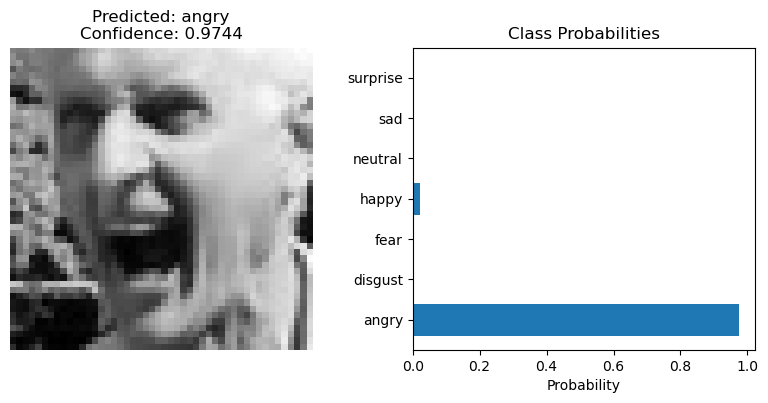

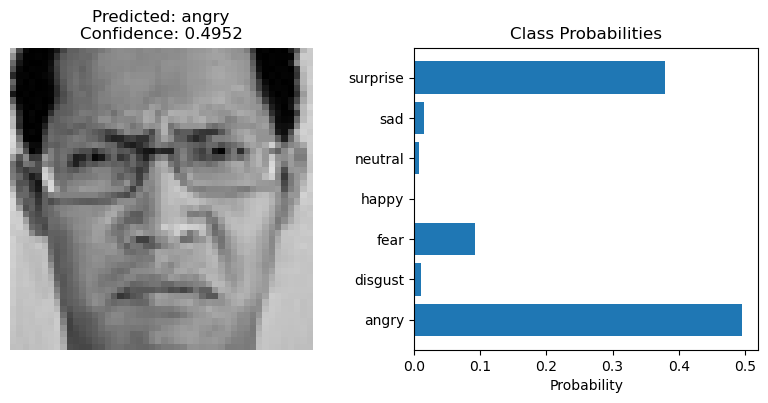

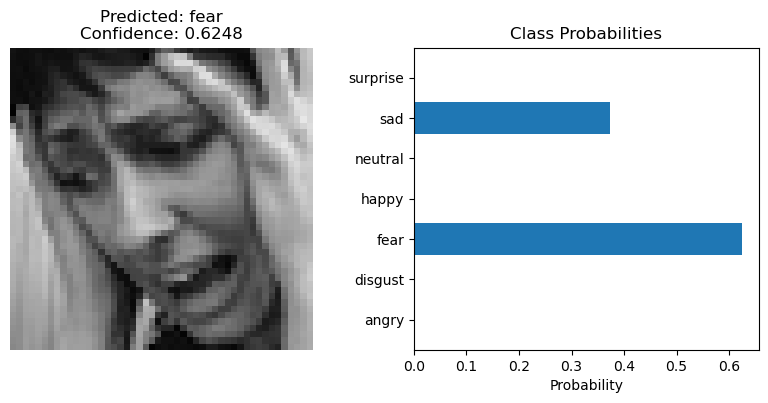

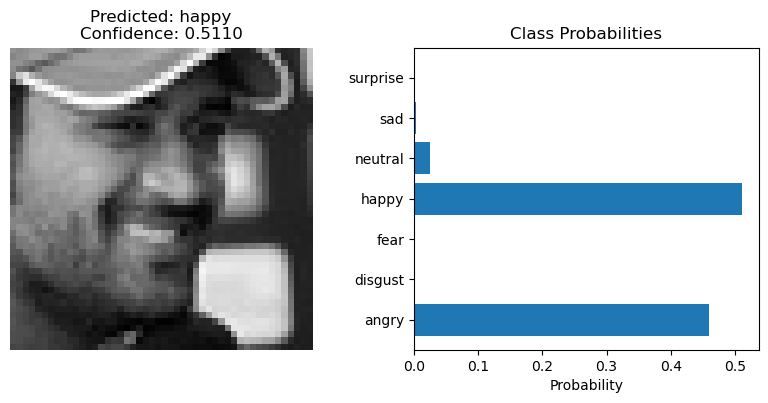

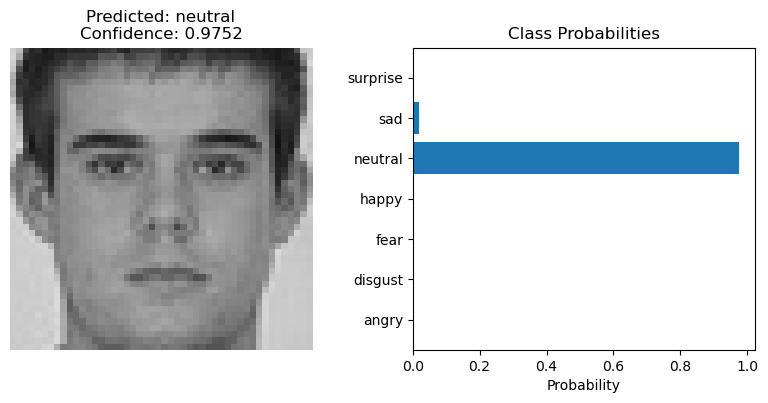

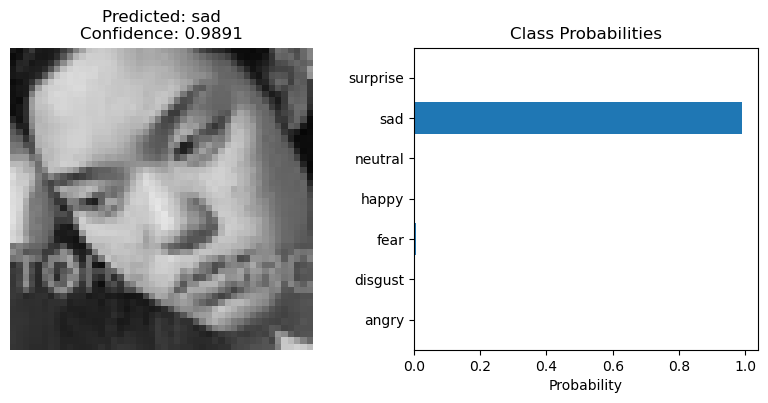

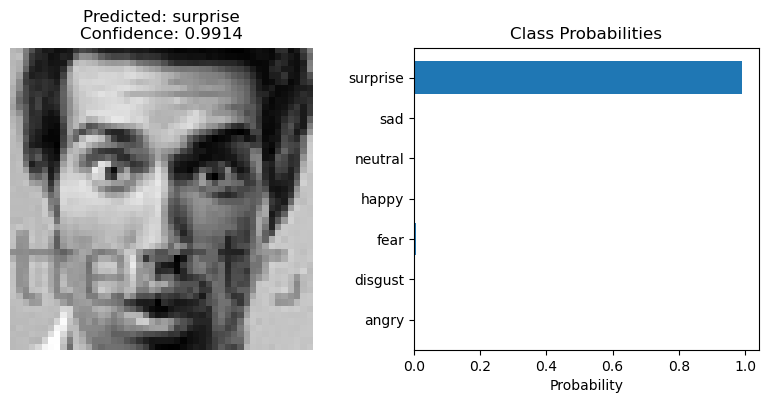

In [26]:
# Function to predict emotion from image
def predict_emotion(model, image_path, transform, class_names, device):
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Predict
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        probs = F.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probs, 1)
    
    # Display results
    plt.figure(figsize=(8, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f'Predicted: {class_names[predicted.item()]}\nConfidence: {confidence.item():.4f}')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    probabilities = probs.cpu().numpy()[0]
    plt.barh(class_names, probabilities)
    plt.xlabel('Probability')
    plt.title('Class Probabilities')
    plt.tight_layout()
    plt.show()
    
    return class_names[predicted.item()], confidence.item()

# Example usage (replace with actual image path)
# predicted_emotion, confidence = predict_emotion(
#     model, 
#     'path_to_your_image.jpg', 
#     val_transform, 
#     class_names, 
#     device
# )

predicted_emotion, confidence = predict_emotion(
    model,
    r"dataset\test\angry\PrivateTest_1109992.jpg",
    val_transform,
    class_names,
    device
)

predicted_emotion, confidence = predict_emotion(
    model,
    r"dataset\test\disgust\PublicTest_48565094.jpg",
    val_transform,
    class_names,
    device
)

predicted_emotion, confidence = predict_emotion(
    model,
    r"dataset\test\fear\PrivateTest_4002000.jpg",
    val_transform,
    class_names,
    device
)

predicted_emotion, confidence = predict_emotion(
    model,
    r"dataset\test\happy\PrivateTest_3362951.jpg",
    val_transform,
    class_names,
    device
)

predicted_emotion, confidence = predict_emotion(
    model,
    r"dataset\test\neutral\PrivateTest_1791924.jpg",
    val_transform,
    class_names,
    device
)

predicted_emotion, confidence = predict_emotion(
    model,
    r"dataset\test\sad\PrivateTest_22673081.jpg",
    val_transform,
    class_names,
    device
)

predicted_emotion, confidence = predict_emotion(
    model,
    r"dataset\test\surprise\PrivateTest_25532192.jpg",
    val_transform,
    class_names,
    device
)